In [1]:
import numpy as np
import pandas as pd
import torch
import os
import time 
import copy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set(font_scale=1)

import importlib
import random 
from skbio import TreeNode
from SimulationResult import SimulationResult
from scipy.spatial.distance import pdist, squareform

In [2]:
## How many cells does the real data end up with?
## Did this seed from one cell? 

import pickle
with open('d21_indel_distributions.p', 'rb') as f:
    indel_distributions = pickle.load(f)

slow_guides = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'TATTGCCTCTTAATCGTCTT']
medium_guides = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TTAAGTTTGAGCTCGCGCAA']
fast_guides = ['TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']
plot_distributions = False
for li in [slow_guides, medium_guides, fast_guides]:
    for guide in li:
        dist = indel_distributions[guide]
        try:
            del dist['']
        except KeyError:
            pass
        
        if plot_distributions:
            distvals = np.array(sorted(list(dist.values()), reverse=True))
            distvals = distvals/distvals.sum()
            plt.figure()
            sns.barplot(np.arange(len(distvals)), distvals, linewidth=0)
            plt.title('Density over different edits for guide {0}'.format(guide))
            plt.show()
            plt.close()

# Estimate the mutation probability

# For a given site E_i[%] = E_{i-1}[%] + p(1-E_{i-1}[%])
# E_i = 1-q^i, where q = 1-p 
# Sanity check: 
# E_0 = 1-(1-p)^0 = 0 
# E_1 = 1-(1-p) = p 

# We can choose to use a combination of varying speed guides 

# 4, 7, 14, 21 days -> 4 generations, 7 generations etc (24 hrs for cell cycle?)

# How many generations does 1 day correspond to?
# Slow guides:
slow = [0.09, 0.15, 0.29, 0.4]

# Medium guides
medium = [0.15, 0.35, 0.6, 0.75]

# Fast guides
fast = [0.75, 0.9, 0.95, 0.96]





Slow
0.02330188829047808
0.02294954933760507
0.02416678505263603
0.024031560532588148
Avg
0.02361244580332683

Medium
0.03981541059581217
0.05968505934696777
0.06335350204906998
0.0638822575463951
Avg
0.056684057384561254

Fast
0.2928932188134524
0.28031432699884795
0.19263617565013524
0.14211035031316765
Avg
0.22698851794390082


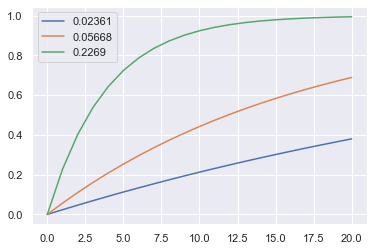

In [3]:
gens = [4,7,14,21]
print('\nSlow')
p_avg = 0
for i, x in enumerate(slow):
    G = 1/gens[i]
    p = 1 - (1-x)**G
    p_avg += p
    print(p)
print("Avg")
print(p_avg/4)

print('\nMedium')
p_avg = 0
for i, x in enumerate(medium):
    G = 1/gens[i]
    p = 1 - (1-x)**G
    p_avg += p
    print(p)
print("Avg")
print(p_avg/4)

print('\nFast')
p_avg = 0
for i, x in enumerate(fast):
    G = 1/gens[i]
    p = 1 - (1-x)**G
    p_avg += p
    print(p)
print("Avg")
print(p_avg/4)    

""" 
Questions
1. tree or forest
2. are the rates based on isolating a clone or from a forest
3. yosef lab was a single tree?? no

try this instead: 
start with many roots (a forest)

reproduction rate varying / same ?vfr 

"""

plt.figure()
for p in [0.02361, 0.05668, 0.2269]:
    q = 1-p
    plt.plot(np.arange(21), 1-q**np.arange(21), label=p)
plt.legend()
plt.show()
plt.close()

rate = {}
rate['slow'] = 0.02361
rate['medium'] = 0.05668
rate['fast'] = 0.2269

## Perform a lineage tracing experiment 

In [4]:
slow_guides = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'TATTGCCTCTTAATCGTCTT']
medium_guides = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TTAAGTTTGAGCTCGCGCAA']
fast_guides = ['TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']

ssm = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT','AATCCCTAGTAGATTAGCCT']
smm = ['AGCTGCTTAGGGCGCAGCCT', 'AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA']
ssf = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'CCTCCCGTAGTGTTGAGTCA']
smf = ['AGCTGCTTAGGGCGCAGCCT', 'AATCCCTAGTAGATTAGCCT', 'CCTCCCGTAGTGTTGAGTCA']
sff = ['AGCTGCTTAGGGCGCAGCCT', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']
mmf = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TAATTCCGGACGAAATCTTG']
mff = ['AATCCCTAGTAGATTAGCCT', 'TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT']


results = {'Guides':[], 'Num_Distinct_Edits':[], 
           'Min_depths':[], 'Num_Mutations':[],
           'Recurring_Characters':[],  
           'Recurring_Characters_%':[],
           'Recurring_Mutations' : [],
           'Recurring_Mutations_%': []
          }

subsampled_results = {'Guides':[], 'Total_Mutations':[], 'Distinct_Mutations':[], 'Recurring_Mutations':[], 'Recurring_Mutations_%':[], 'Unique_Cells': [] }

timers = {}

lists_of_guides = [smf]
labels = ['smf']

verbose = False
tree_depth = 20
num_runs = 3
n_subsample = 400
num_arrays = 10


init_cell_list = [1]#, 10, 50, 100]
death_rep_probs = [(0.1, 0.75)] #, (0.2, 0.75), (0.1,0.9)]
cancer_probs = [1e-3] #, 1e-2]
missing_fracs = [0.2, 0.1, 0.05, 0.01, 0]

debug = False
compute_tree = False

if debug:
    lists_of_guides = [fast_guides]
    labels = ['smf']
    tree_depth = 20
    num_runs = 1
    n_subsample = 500
    num_arrays = 10
    init_cell_list = [1]
    
    death_rep_probs = [(0.1, 0.75)]
    cancer_probs = [1e-3]
    
    missing_fracs = [0.01]

Label: smf
List of targets:  [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2), (5, 0), (5, 1), (5, 2), (6, 0), (6, 1), (6, 2), (7, 0), (7, 1), (7, 2), (8, 0), (8, 1), (8, 2), (9, 0), (9, 1), (9, 2)]
Generation: 0
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19
drop 2400 (400, 30)


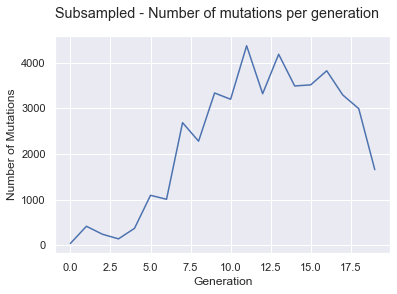

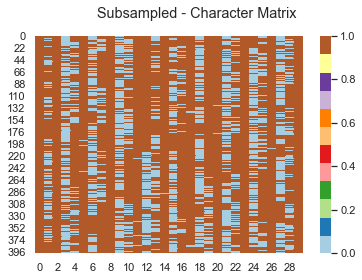

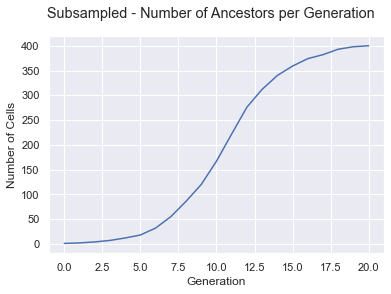

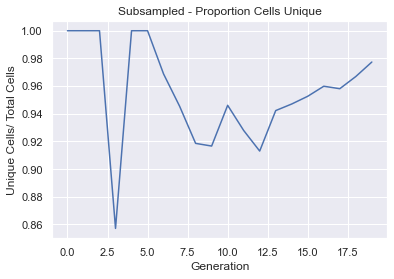

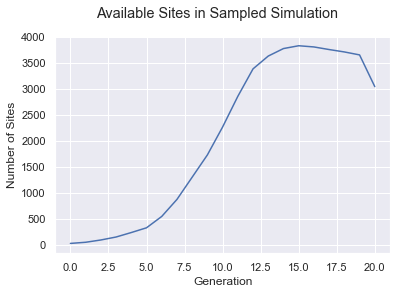

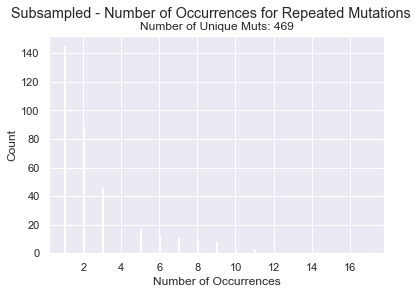

Reconstructing greedy tree
Getting tree with missing data.
Got true_tree
Computing score before reassignment.
Score before reassignment:  0.456
Reassigned 347 leaves out of a total of 400 leaves.
Removed 13 leaves after reassigning cells.
Score after reassignment:  0.471
Starting NJ with 19 nodes
Starting NJ with 36 nodes
Starting NJ with 19 nodes
Starting NJ with 13 nodes
Starting NJ with 14 nodes
Starting NJ with 17 nodes
Starting NJ with 34 nodes
Starting NJ with 20 nodes
Starting NJ with 48 nodes
Starting NJ with 42 nodes


/Users/sitarapersad/PycharmProjects/lineageTracing/modified_nj.py:52: RuntimeWarning: invalid value encountered in subtract
  Q = D*(fm.shape[0]-2) - R


Starting NJ with 35 nodes
Starting NJ with 30 nodes
Starting NJ with 30 nodes
Starting NJ with 30 nodes
Starting NJ with 13 nodes
Score after neighbor joining:  0.445


/Users/sitarapersad/.local/lib/python3.8/site-packages/cassiopeia/TreeSolver/lineage_solver/ILP_solver.py:11: UserWarning: No module called gurobipy found. ILP solver will exit automatically if used.
  warnings.warn("No module called gurobipy found. ILP solver will exit automatically if used.")


Reconstructing Cassiopeia Tree
Getting tree with missing data.
Failed to find 8 triplets out of 1000 due to nodes missing from reconstructed tree.
Cassiopeia: 0.9304435483870968
Generation: 0
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19
drop 2400 (400, 30)


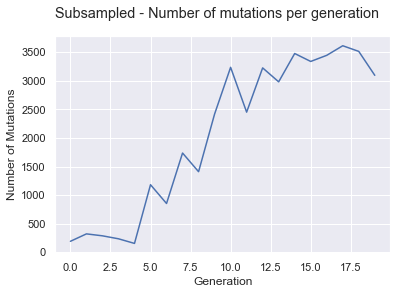

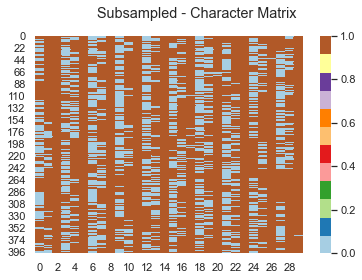

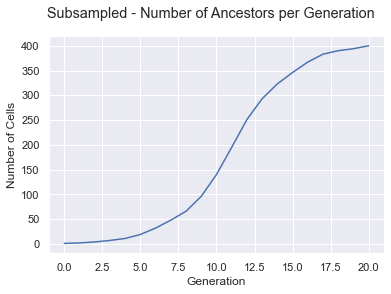

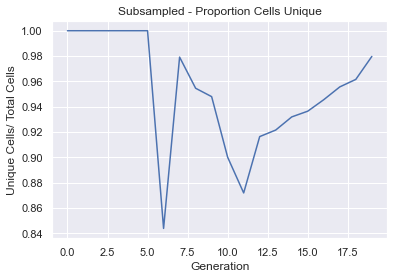

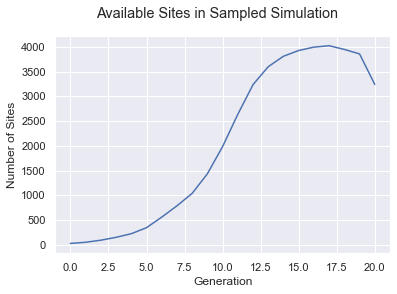

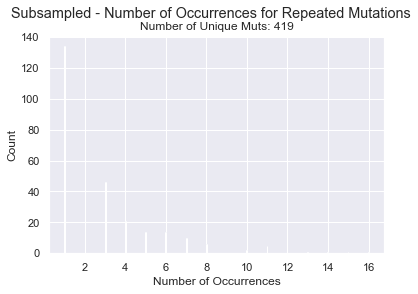

Reconstructing greedy tree
Getting tree with missing data.
Got true_tree
Computing score before reassignment.
Score before reassignment:  0.443
Reassigned 326 leaves out of a total of 400 leaves.
Removed 10 leaves after reassigning cells.
Score after reassignment:  0.472
Starting NJ with 39 nodes
Starting NJ with 45 nodes
Starting NJ with 27 nodes
Starting NJ with 27 nodes
Starting NJ with 35 nodes
Starting NJ with 29 nodes
Starting NJ with 26 nodes


/Users/sitarapersad/PycharmProjects/lineageTracing/modified_nj.py:52: RuntimeWarning: invalid value encountered in subtract
  Q = D*(fm.shape[0]-2) - R


Starting NJ with 41 nodes
Starting NJ with 35 nodes
Starting NJ with 29 nodes
Starting NJ with 50 nodes
Starting NJ with 17 nodes
Score after neighbor joining:  0.46
Reconstructing Cassiopeia Tree
Getting tree with missing data.
Cassiopeia: 0.971
Generation: 0
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19
drop 2400 (400, 30)


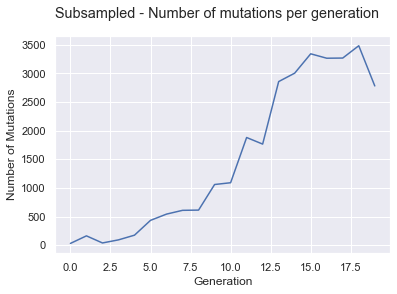

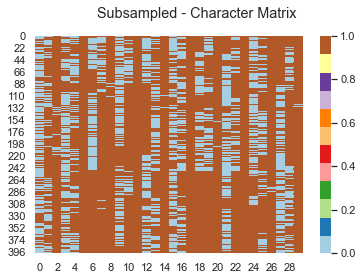

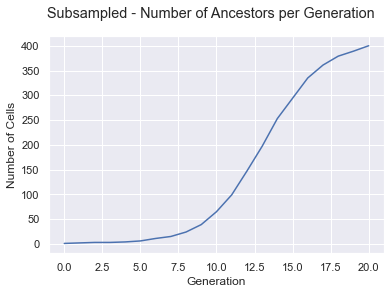

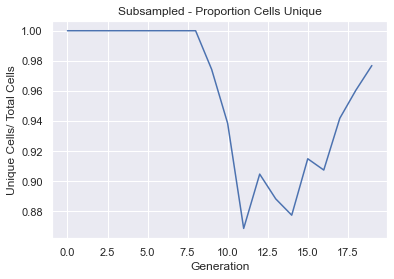

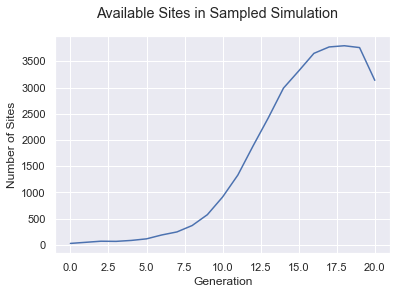

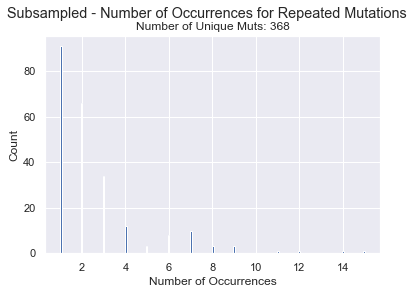

Reconstructing greedy tree
Getting tree with missing data.
Got true_tree
Computing score before reassignment.
Score before reassignment:  0.541
Reassigned 264 leaves out of a total of 400 leaves.
Removed 12 leaves after reassigning cells.
Score after reassignment:  0.586
Starting NJ with 47 nodes
Starting NJ with 14 nodes
Starting NJ with 43 nodes
Starting NJ with 17 nodes
Starting NJ with 41 nodes
Starting NJ with 22 nodes
Starting NJ with 46 nodes
Starting NJ with 6 nodes
Starting NJ with 12 nodes
Starting NJ with 16 nodes


/Users/sitarapersad/PycharmProjects/lineageTracing/modified_nj.py:52: RuntimeWarning: invalid value encountered in subtract
  Q = D*(fm.shape[0]-2) - R


Starting NJ with 15 nodes
Starting NJ with 16 nodes
Starting NJ with 36 nodes
Starting NJ with 36 nodes
Starting NJ with 33 nodes
Score after neighbor joining:  0.559
Reconstructing Cassiopeia Tree
Getting tree with missing data.
Failed to find 22 triplets out of 1000 due to nodes missing from reconstructed tree.
Cassiopeia: 0.9856850715746421
Label: smf
List of targets:  [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2), (5, 0), (5, 1), (5, 2), (6, 0), (6, 1), (6, 2), (7, 0), (7, 1), (7, 2), (8, 0), (8, 1), (8, 2), (9, 0), (9, 1), (9, 2)]
Generation: 0
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19
drop 1200 (400, 30)


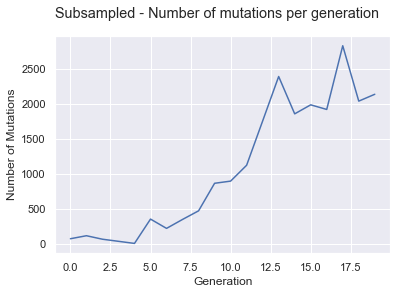

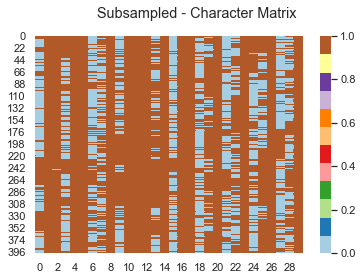

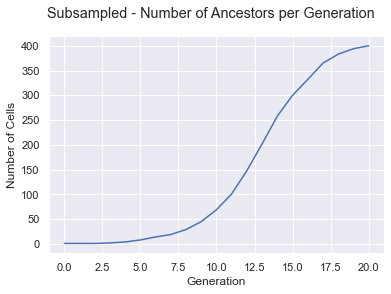

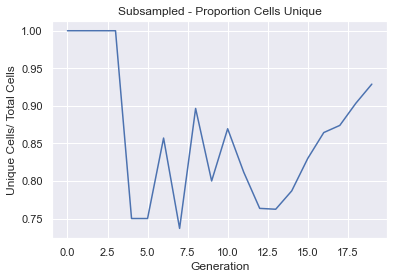

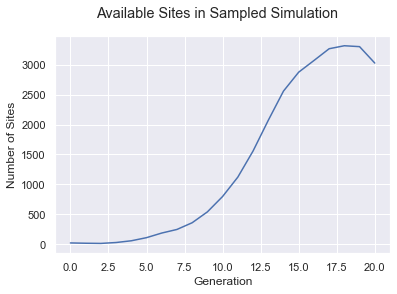

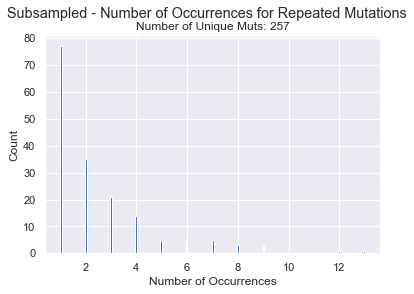

Reconstructing greedy tree
Getting tree with missing data.
Got true_tree
Computing score before reassignment.
Score before reassignment:  0.355
Reassigned 387 leaves out of a total of 400 leaves.
Removed 16 leaves after reassigning cells.
Score after reassignment:  0.34
Starting NJ with 13 nodes
Starting NJ with 45 nodes
Starting NJ with 37 nodes
Starting NJ with 16 nodes
Starting NJ with 14 nodes
Starting NJ with 15 nodes
Starting NJ with 17 nodes
Starting NJ with 15 nodes
Starting NJ with 19 nodes
Starting NJ with 21 nodes
Starting NJ with 24 nodes
Starting NJ with 24 nodes
Starting NJ with 26 nodes


/Users/sitarapersad/PycharmProjects/lineageTracing/modified_nj.py:52: RuntimeWarning: invalid value encountered in subtract
  Q = D*(fm.shape[0]-2) - R


Starting NJ with 28 nodes
Starting NJ with 29 nodes
Starting NJ with 27 nodes
Starting NJ with 30 nodes
Score after neighbor joining:  0.31
Reconstructing Cassiopeia Tree
Getting tree with missing data.
Failed to find 102 triplets out of 1000 due to nodes missing from reconstructed tree.
Cassiopeia: 0.6759465478841871
Generation: 0
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19
drop 1200 (400, 30)


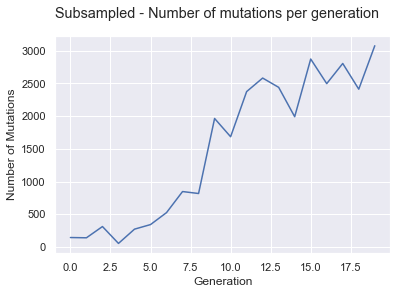

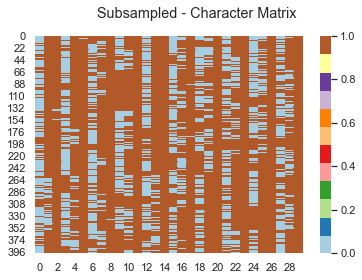

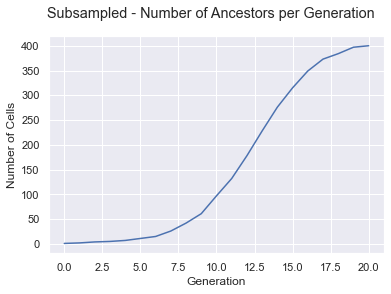

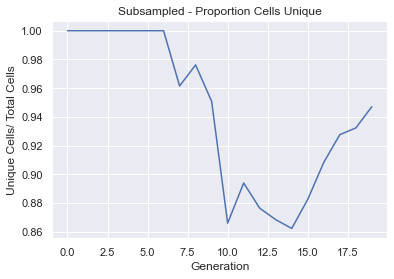

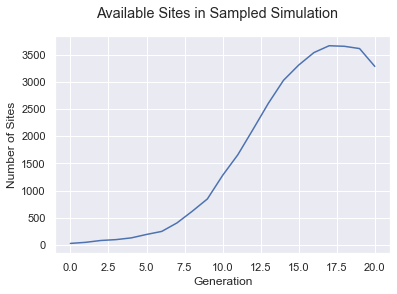

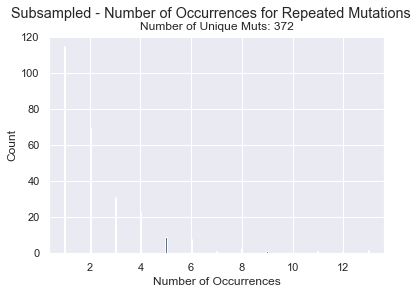

Reconstructing greedy tree
Getting tree with missing data.
Got true_tree
Computing score before reassignment.
Score before reassignment:  0.515
Reassigned 278 leaves out of a total of 400 leaves.
Removed 15 leaves after reassigning cells.
Score after reassignment:  0.521
Starting NJ with 29 nodes
Starting NJ with 22 nodes
Starting NJ with 6 nodes
Starting NJ with 6 nodes
Starting NJ with 47 nodes
Starting NJ with 13 nodes
Starting NJ with 20 nodes
Starting NJ with 22 nodes
Starting NJ with 17 nodes
Starting NJ with 46 nodes
Starting NJ with 6 nodes
Starting NJ with 22 nodes
Starting NJ with 10 nodes


/Users/sitarapersad/PycharmProjects/lineageTracing/modified_nj.py:52: RuntimeWarning: invalid value encountered in subtract
  Q = D*(fm.shape[0]-2) - R


Starting NJ with 5 nodes
Starting NJ with 18 nodes
Starting NJ with 35 nodes
Starting NJ with 42 nodes
Starting NJ with 34 nodes
Score after neighbor joining:  0.519
Reconstructing Cassiopeia Tree
Getting tree with missing data.
Failed to find 22 triplets out of 1000 due to nodes missing from reconstructed tree.
Cassiopeia: 0.9325153374233128
Generation: 0
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19
drop 1200 (400, 30)


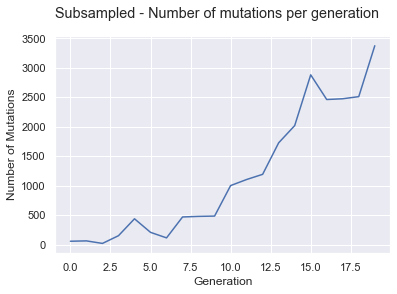

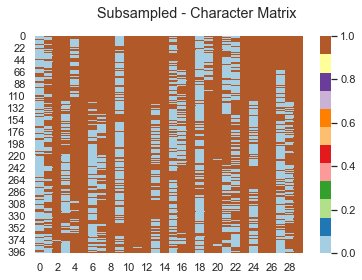

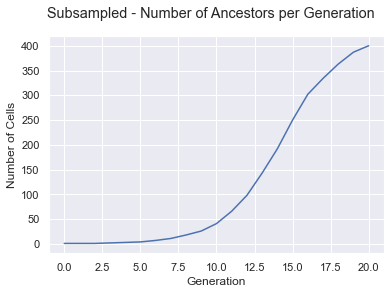

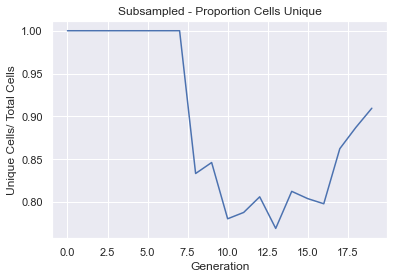

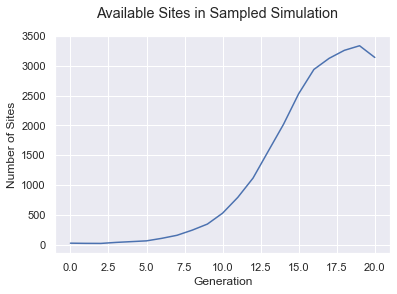

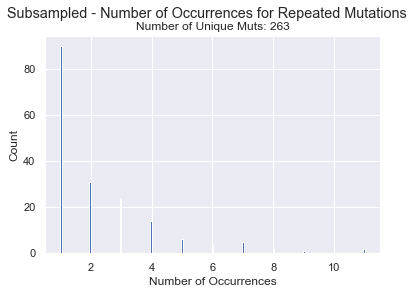

Reconstructing greedy tree
Getting tree with missing data.
Got true_tree
Computing score before reassignment.
Score before reassignment:  0.391
Reassigned 364 leaves out of a total of 400 leaves.
Removed 15 leaves after reassigning cells.
Score after reassignment:  0.399
Starting NJ with 32 nodes
Starting NJ with 34 nodes
Starting NJ with 12 nodes
Starting NJ with 6 nodes
Starting NJ with 23 nodes
Starting NJ with 14 nodes
Starting NJ with 22 nodes
Starting NJ with 48 nodes
Starting NJ with 3 nodes
Starting NJ with 4 nodes
Starting NJ with 2 nodes
Starting NJ with 19 nodes
Starting NJ with 28 nodes
Starting NJ with 24 nodes


/Users/sitarapersad/PycharmProjects/lineageTracing/modified_nj.py:52: RuntimeWarning: invalid value encountered in subtract
  Q = D*(fm.shape[0]-2) - R


Starting NJ with 25 nodes
Starting NJ with 25 nodes
Starting NJ with 26 nodes
Starting NJ with 28 nodes
Starting NJ with 25 nodes
Score after neighbor joining:  0.381
Reconstructing Cassiopeia Tree
Getting tree with missing data.
Failed to find 58 triplets out of 1000 due to nodes missing from reconstructed tree.
Cassiopeia: 0.9193205944798302
Label: smf
List of targets:  [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2), (5, 0), (5, 1), (5, 2), (6, 0), (6, 1), (6, 2), (7, 0), (7, 1), (7, 2), (8, 0), (8, 1), (8, 2), (9, 0), (9, 1), (9, 2)]
Generation: 0
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19
drop 600 (400, 30)


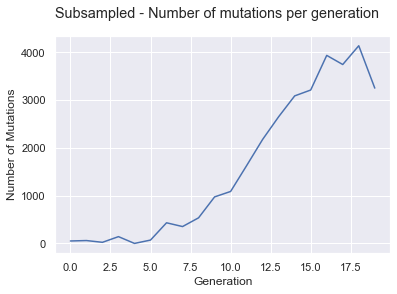

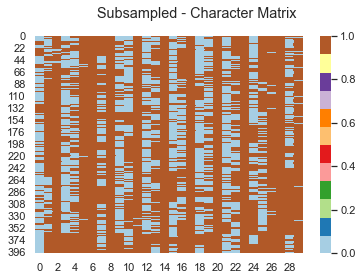

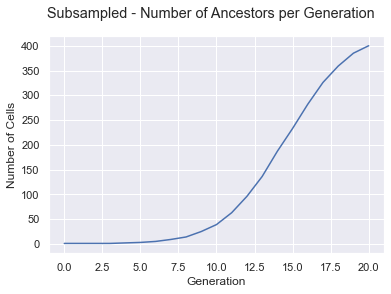

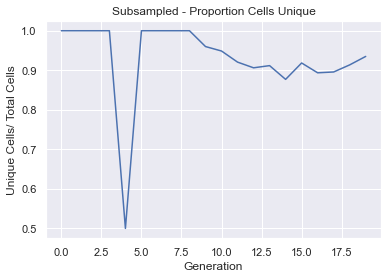

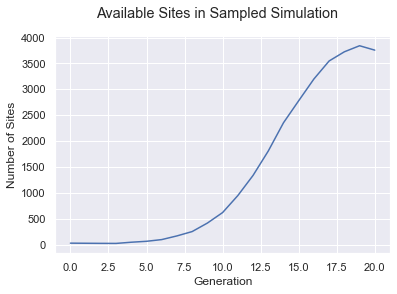

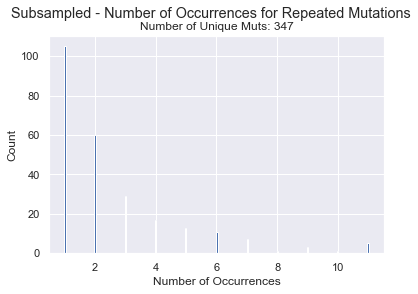

Reconstructing greedy tree
Getting tree with missing data.
Got true_tree
Computing score before reassignment.
Score before reassignment:  0.489
Reassigned 259 leaves out of a total of 399 leaves.
Removed 13 leaves after reassigning cells.
Score after reassignment:  0.484
Starting NJ with 31 nodes
Starting NJ with 31 nodes
Starting NJ with 41 nodes
Starting NJ with 10 nodes
Starting NJ with 37 nodes
Starting NJ with 35 nodes
Starting NJ with 32 nodes
Starting NJ with 34 nodes
Starting NJ with 19 nodes


/Users/sitarapersad/PycharmProjects/lineageTracing/modified_nj.py:52: RuntimeWarning: invalid value encountered in subtract
  Q = D*(fm.shape[0]-2) - R


Starting NJ with 14 nodes
Starting NJ with 22 nodes
Starting NJ with 19 nodes
Starting NJ with 18 nodes
Starting NJ with 16 nodes
Starting NJ with 15 nodes
Starting NJ with 14 nodes
Starting NJ with 11 nodes
Score after neighbor joining:  0.492
Reconstructing Cassiopeia Tree
Getting tree with missing data.
Failed to find 209 triplets out of 1000 due to nodes missing from reconstructed tree.
Cassiopeia: 0.888748419721871
Generation: 0
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19
drop 600 (400, 30)


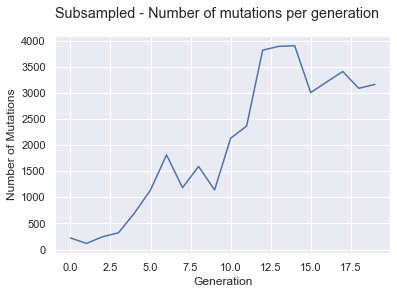

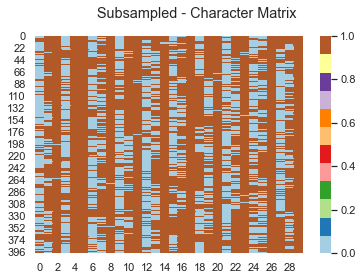

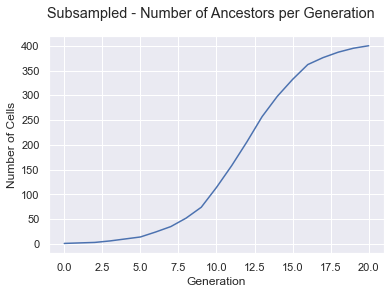

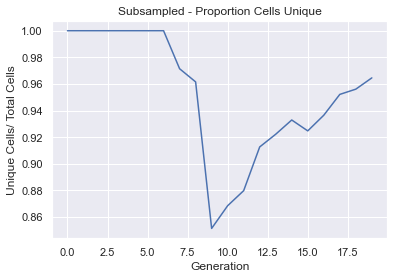

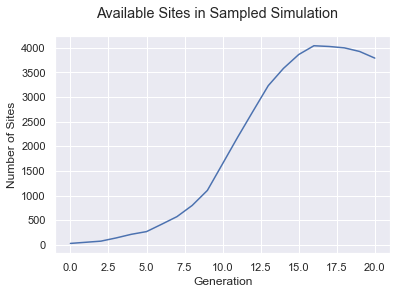

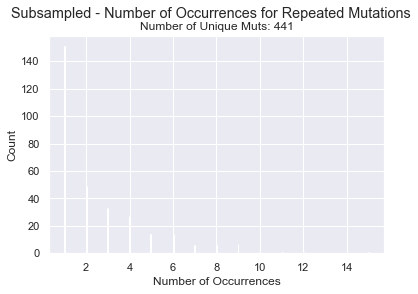

Reconstructing greedy tree
Getting tree with missing data.
Got true_tree
Computing score before reassignment.
Score before reassignment:  0.545
shapes (1241,844) and (843,20) not aligned: 844 (dim 1) != 843 (dim 0)
Generation: 0
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19
drop 600 (400, 30)


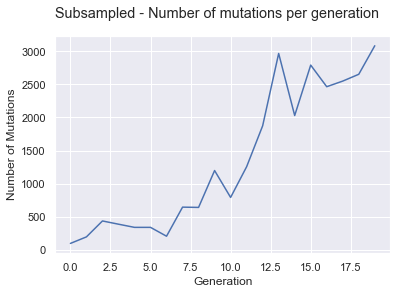

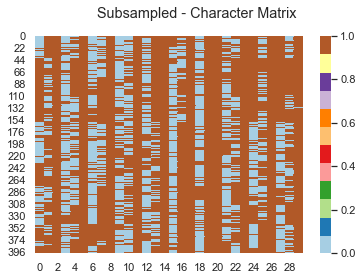

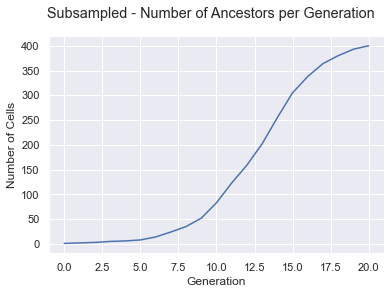

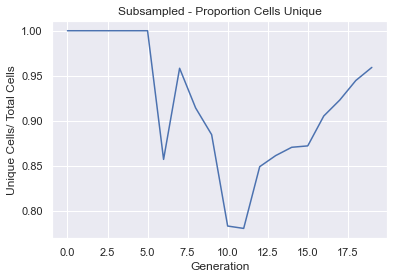

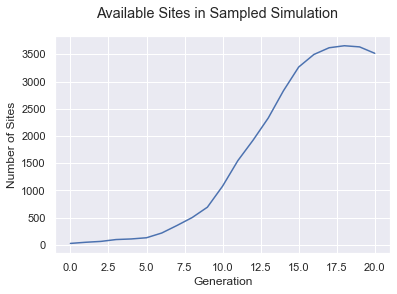

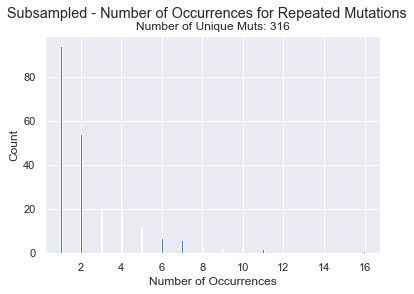

Reconstructing greedy tree
Getting tree with missing data.
Got true_tree
Computing score before reassignment.
Score before reassignment:  0.646
Reassigned 280 leaves out of a total of 399 leaves.
Removed 20 leaves after reassigning cells.
Score after reassignment:  0.633
Starting NJ with 41 nodes
Starting NJ with 39 nodes
Starting NJ with 3 nodes


/Users/sitarapersad/PycharmProjects/lineageTracing/modified_nj.py:52: RuntimeWarning: invalid value encountered in subtract
  Q = D*(fm.shape[0]-2) - R


Starting NJ with 43 nodes
Starting NJ with 28 nodes
Starting NJ with 6 nodes
Starting NJ with 4 nodes
Starting NJ with 11 nodes
Starting NJ with 12 nodes
Starting NJ with 7 nodes
Starting NJ with 42 nodes
Starting NJ with 25 nodes
Starting NJ with 4 nodes
Starting NJ with 29 nodes
Starting NJ with 7 nodes
Starting NJ with 6 nodes
Starting NJ with 3 nodes
Starting NJ with 4 nodes
Starting NJ with 4 nodes
Starting NJ with 4 nodes
Starting NJ with 3 nodes
Starting NJ with 9 nodes
Starting NJ with 26 nodes
Starting NJ with 21 nodes
Starting NJ with 18 nodes
Score after neighbor joining:  0.632
Reconstructing Cassiopeia Tree
Getting tree with missing data.
Failed to find 112 triplets out of 1000 due to nodes missing from reconstructed tree.
Cassiopeia: 0.7747747747747747
Label: smf
List of targets:  [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2), (5, 0), (5, 1), (5, 2), (6, 0), (6, 1), (6, 2), (7, 0), (7, 1), (7, 2), (

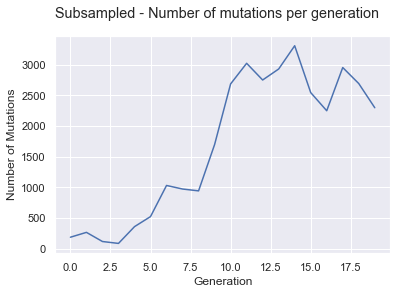

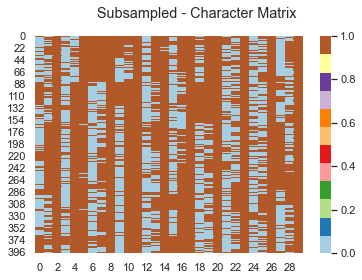

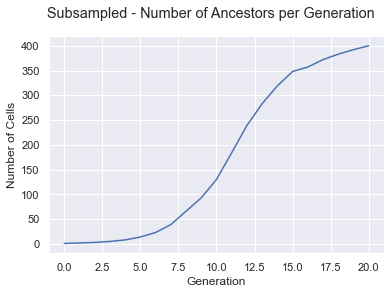

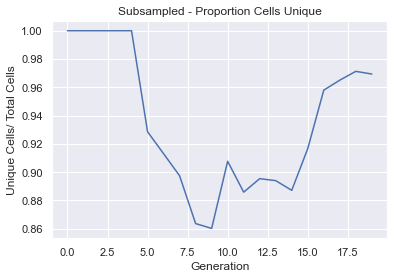

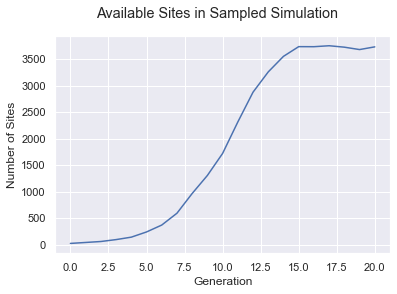

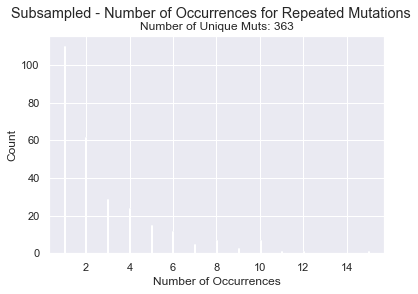

Reconstructing greedy tree
Getting tree with missing data.
Got true_tree
Computing score before reassignment.
Score before reassignment:  0.862
shapes (1856,735) and (734,26) not aligned: 735 (dim 1) != 734 (dim 0)
Generation: 0
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19
drop 120 (400, 30)


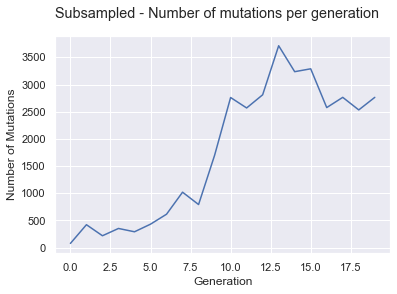

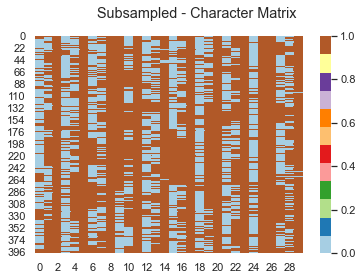

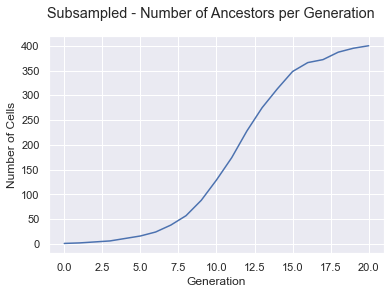

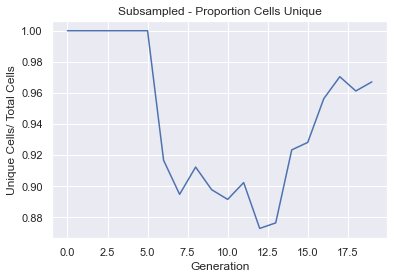

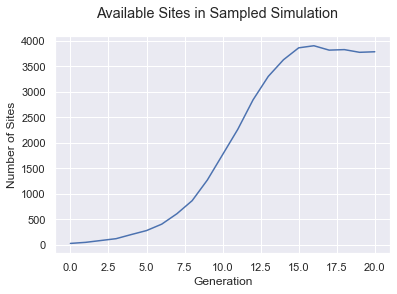

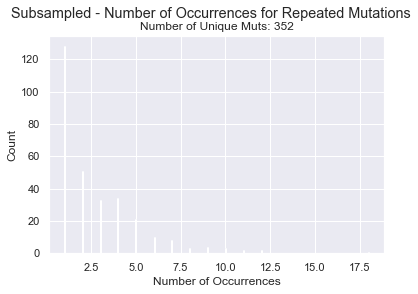

Reconstructing greedy tree
Getting tree with missing data.
Got true_tree
Computing score before reassignment.
9 triplets contained nodes which exist as duplicates across different branches in original tree.
Score before reassignment:  0.938
shapes (2681,766) and (765,24) not aligned: 766 (dim 1) != 765 (dim 0)
Generation: 0
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19
drop 120 (400, 30)


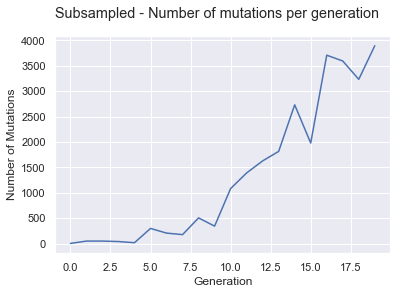

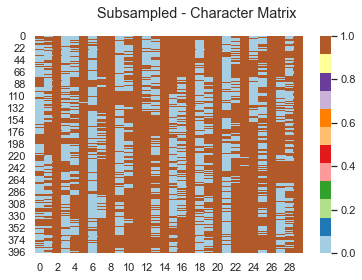

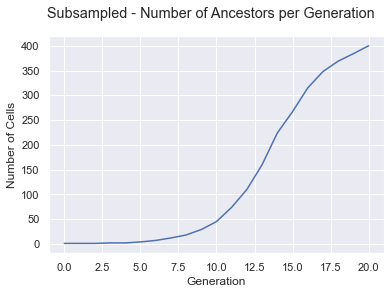

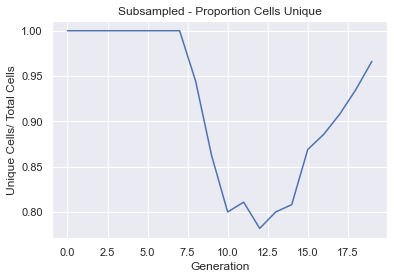

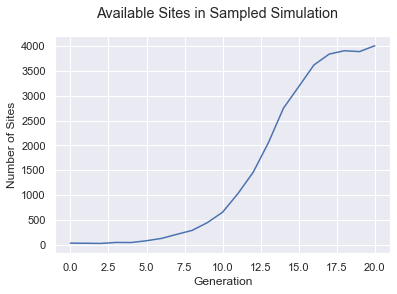

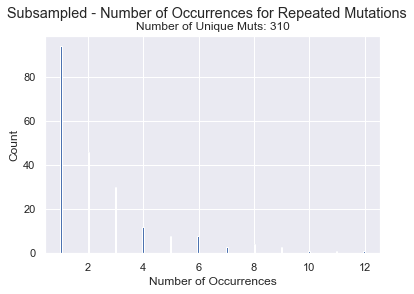

Reconstructing greedy tree
Getting tree with missing data.
Got true_tree
Computing score before reassignment.
6 triplets contained nodes which exist as duplicates across different branches in original tree.
Score before reassignment:  0.825
shapes (995,616) and (615,25) not aligned: 616 (dim 1) != 615 (dim 0)
Label: smf
List of targets:  [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2), (5, 0), (5, 1), (5, 2), (6, 0), (6, 1), (6, 2), (7, 0), (7, 1), (7, 2), (8, 0), (8, 1), (8, 2), (9, 0), (9, 1), (9, 2)]
Generation: 0
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19


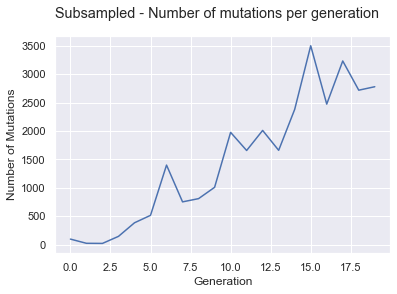

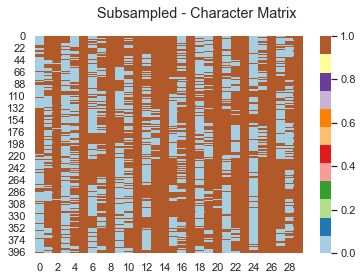

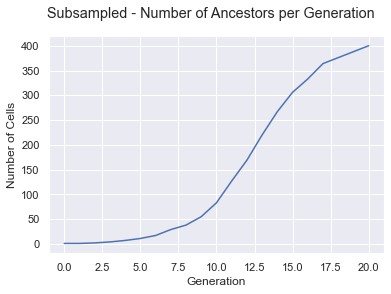

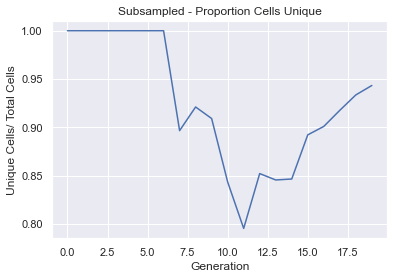

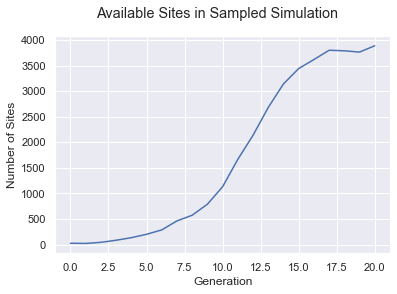

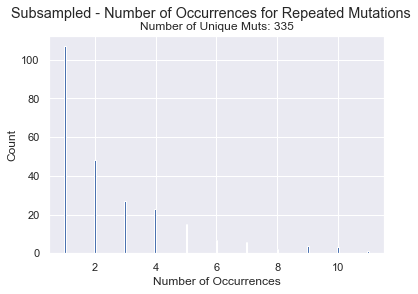

Reconstructing greedy tree
Getting tree with missing data.
Got true_tree
Computing score before reassignment.
26 triplets contained nodes which exist as duplicates across different branches in original tree.
Score before reassignment:  0.981
shapes (1035,671) and (670,13) not aligned: 671 (dim 1) != 670 (dim 0)
Generation: 0
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19


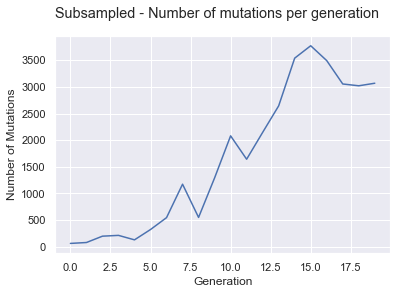

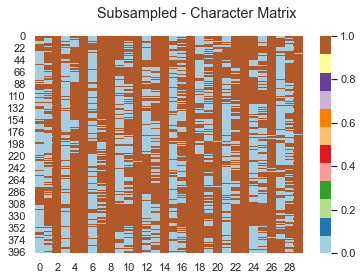

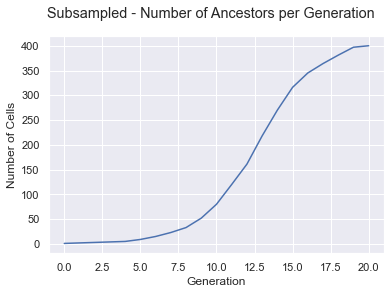

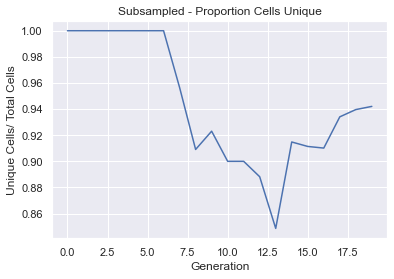

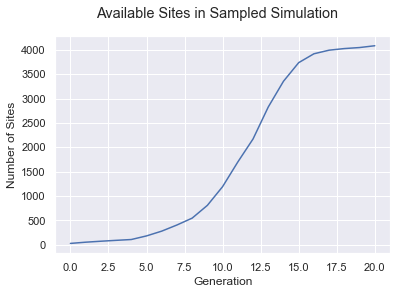

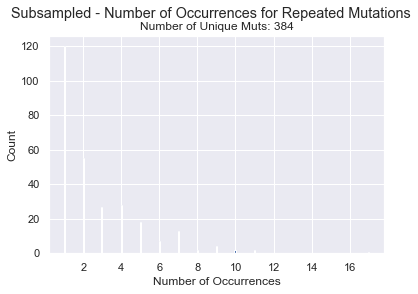

Reconstructing greedy tree
Getting tree with missing data.
Got true_tree
Computing score before reassignment.
32 triplets contained nodes which exist as duplicates across different branches in original tree.
Score before reassignment:  0.916
Reassigned 82 leaves out of a total of 374 leaves.
Removed 2 leaves after reassigning cells.
36 triplets contained nodes which exist as duplicates across different branches in original tree.
Score after reassignment:  0.928
Starting NJ with 37 nodes
Starting NJ with 25 nodes
Starting NJ with 29 nodes
Starting NJ with 11 nodes
Starting NJ with 38 nodes
Starting NJ with 24 nodes
Starting NJ with 38 nodes
Starting NJ with 5 nodes


/Users/sitarapersad/PycharmProjects/lineageTracing/modified_nj.py:52: RuntimeWarning: invalid value encountered in subtract
  Q = D*(fm.shape[0]-2) - R


Starting NJ with 48 nodes
Starting NJ with 43 nodes
Starting NJ with 43 nodes
Starting NJ with 33 nodes
34 triplets contained nodes which exist as duplicates across different branches in original tree.
Score after neighbor joining:  0.95
Reconstructing Cassiopeia Tree
Getting tree with missing data.
Failed to find 294 triplets out of 1000 due to nodes missing from reconstructed tree.
31 triplets contained nodes which exist as duplicates across different branches in original tree.
Cassiopeia: 0.9518413597733711
Generation: 0
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19


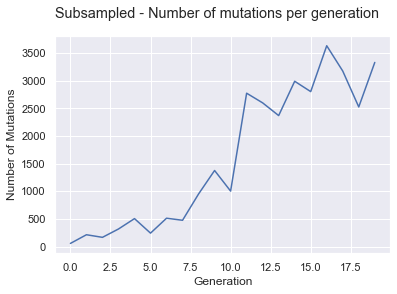

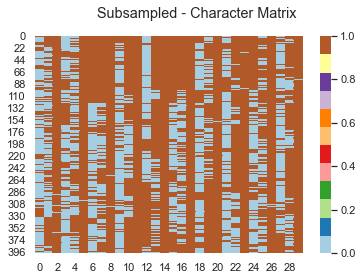

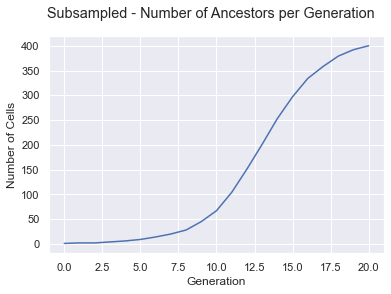

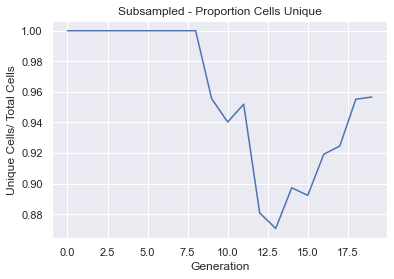

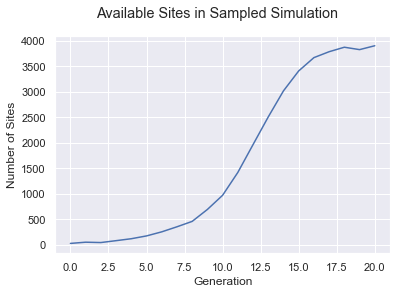

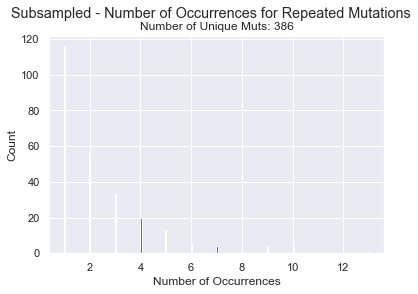

Reconstructing greedy tree
Getting tree with missing data.
Got true_tree
Computing score before reassignment.
Score before reassignment:  0.962
shapes (1883,756) and (755,13) not aligned: 756 (dim 1) != 755 (dim 0)


In [5]:
import crispr_lib
importlib.reload(crispr_lib)

simulation_list = []


missing_results = {'params':[('death_prob', 'rep_prob','cancer_prob','guide','init_cells','run','missing_frac')], 
           'outcomes':[('greedy_tree', 'scores', 'cass_tree', 'cass_scores', 'simulation')]}

for missing_frac in missing_fracs:
    for init_death_prob, init_repr_prob in death_rep_probs:
        for cancer_prob in cancer_probs:
            for i, list_of_guides in enumerate(lists_of_guides):
                label = labels[i]
                print('Label:', label)

                # Each array has 3-6 targets, we insert ~10 arrays. This gives us 30-60 sites
                site_ix = 0
                target_distributions = {}
                speed = {}
                for guide in list_of_guides:
                    dist = indel_distributions[guide]
                    try:
                        del dist['']
                    except KeyError:
                        pass
                    distvals = np.array(sorted(list(dist.values()), reverse=True))
                    distvals = distvals/distvals.sum()
                    target_distributions[site_ix] = distvals
                    if guide in slow_guides:
                        speed[site_ix] = 'slow'
                    elif guide in medium_guides:
                        speed[site_ix] = 'medium'
                    else:
                        speed[site_ix] = 'fast'

                    site_ix += 1

                num_targets = site_ix 
                num_edit_sites = num_targets * num_arrays

                import itertools
                targets = list(itertools.product(np.arange(num_arrays), np.arange(num_targets)))
                print('List of targets: ', targets)

                deletions = []
                mutation_probs = []
                for array, target in targets:
                    deletions.append(target_distributions[target])
                    mutation_probs.append(rate[speed[target]])

                deletions_probs = pd.DataFrame(deletions)
                deletions_probs = torch.DoubleTensor(deletions_probs.fillna(0.0).values)

                # Each edit site has a different mutation probability 
                mutation_probs= np.array(mutation_probs)

                deletions_probs = deletions_probs[:, :100]
                deletions_probs /= deletions_probs.sum(1, keepdims=True)

                edit_probs = np.hstack([mutation_probs.reshape(-1,1), (1-mutation_probs.reshape(-1,1))*deletions_probs.numpy()])



                for init_cells in init_cell_list:

                    for run in range(num_runs):

                        try:
                            try:
                                simulation = crispr_lib.lineageSimulationImbalanced(label, tree_depth, 
                                                                         num_edit_sites, deletions_probs, 
                                                                         mutation_probs, edit_probs, 
                                                                         init_cells=init_cells, 
                                                                         n_subsample=n_subsample,
                                                                         missing_fraction= missing_frac,
                                                                         identify_recurrent_muts=False)
                            except:
                                # If simulation fails, try again to generate sufficient cells
                                simulation = crispr_lib.lineageSimulationImbalanced(label, tree_depth, 
                                                                         num_edit_sites, deletions_probs, 
                                                                         mutation_probs, edit_probs, 
                                                                         init_cells=init_cells, 
                                                                         n_subsample=n_subsample,
                                                                         missing_fraction=missing_frac, 
                                                                         identify_recurrent_muts=False)


                            simulation_list.append(simulation)

                            ## Benchmark reconstruction performance on this simulation (Cassiopeia vs Greedy + NJ)
                            from greedy_reconstruct import greedy_probabilistic
                            # Compute reconstruction accuracy from greedy + reassignment method
                            greedy_tree, scores = greedy_probabilistic(simulation,
                                                           impute_missing_data=False,
                                                           max_cells_per_greedy_node = 50)

                            from cass_helper import cassiopeia_reconstruct

                            from cassiopeia.TreeSolver.Cassiopeia_Tree import Cassiopeia_Tree
                            from cassiopeia.TreeSolver.score_triplets import score_triplets
                            from cassiopeia.TreeSolver.Node import Node 
                            from cassiopeia.TreeSolver.lineage_solver.lineage_solver import solve_lineage_instance

                            # Compute Cassiopeia reconstruction accuracy
                            cass_tree, cass_scores = cassiopeia_reconstruct(simulation)
                            
                            missing_results['params'].append((init_death_prob, init_repr_prob, cancer_prob, label, init_cells, run, missing_frac))
                            missing_results['outcomes'].append((greedy_tree, scores, cass_tree, cass_scores, simulation))
                            
                        except Exception as e:
                            print(e)
                            missing_results['params'].append((init_death_prob, init_repr_prob, cancer_prob, label, init_cells, run, missing_frac))
                            missing_results['outcomes'].append((e, simulation))

## Tree Reconstructions 

Compare various methods of tree reconstruction to determine which has the best performance

In [11]:
imputed_results = {'params':[], 'outcomes':[]}
params = missing_results['params'][1:]

for i, params in enumerate(params):
    simulation = simulation_list[i]
    imputed_results['params'].append(params)
    
    try:
        greedy_tree, scores = greedy_probabilistic(simulation,
                                                   impute_missing_data=True,
                                                   max_cells_per_greedy_node = 50)

        imputed_results['outcomes'].append((greedy_tree, scores))
    except Exception as e:
        imputed_results['outcomes'].append((simulation, e))

Reconstructing greedy tree
Getting tree with imputed data.
Got true_tree
Computing score before reassignment.
Score before reassignment:  0.895
Reconstructing greedy tree
Getting tree with imputed data.
Got true_tree
Computing score before reassignment.
Score before reassignment:  0.928
Reconstructing greedy tree
Getting tree with imputed data.
Got true_tree
Computing score before reassignment.
Score before reassignment:  0.972
Reconstructing greedy tree
Getting tree with imputed data.
Got true_tree
Computing score before reassignment.
58 triplets contained nodes which exist as duplicates across different branches in original tree.
Score before reassignment:  0.661
Reassigned 164 leaves out of a total of 387 leaves.
Removed 6 leaves after reassigning cells.
48 triplets contained nodes which exist as duplicates across different branches in original tree.
Score after reassignment:  0.67
Starting NJ with 14 nodes
Starting NJ with 47 nodes
Starting NJ with 50 nodes
Starting NJ with 2 nodes

/Users/sitarapersad/PycharmProjects/lineageTracing/modified_nj.py:52: RuntimeWarning: invalid value encountered in subtract
  Q = D*(fm.shape[0]-2) - R


Starting NJ with 46 nodes
Starting NJ with 21 nodes
Starting NJ with 9 nodes
Starting NJ with 47 nodes
49 triplets contained nodes which exist as duplicates across different branches in original tree.
Score after neighbor joining:  0.638
Reconstructing greedy tree
Getting tree with imputed data.
Got true_tree
Computing score before reassignment.
55 triplets contained nodes which exist as duplicates across different branches in original tree.
Score before reassignment:  0.883
Reconstructing greedy tree
Getting tree with imputed data.
Got true_tree
Computing score before reassignment.
28 triplets contained nodes which exist as duplicates across different branches in original tree.
Score before reassignment:  0.9
Reconstructing greedy tree
Getting tree with imputed data.
Got true_tree
Computing score before reassignment.
20 triplets contained nodes which exist as duplicates across different branches in original tree.
Score before reassignment:  0.857
Reassigned 147 leaves out of a total o

/Users/sitarapersad/PycharmProjects/lineageTracing/modified_nj.py:52: RuntimeWarning: invalid value encountered in subtract
  Q = D*(fm.shape[0]-2) - R


Starting NJ with 5 nodes
Starting NJ with 26 nodes
Starting NJ with 48 nodes
Starting NJ with 26 nodes
Starting NJ with 5 nodes
26 triplets contained nodes which exist as duplicates across different branches in original tree.
Score after neighbor joining:  0.87
Reconstructing greedy tree
Getting tree with imputed data.
Got true_tree
Computing score before reassignment.
Score before reassignment:  0.744
Reassigned 110 leaves out of a total of 393 leaves.
Removed 5 leaves after reassigning cells.
Score after reassignment:  0.741
Starting NJ with 46 nodes
Starting NJ with 21 nodes
Starting NJ with 2 nodes
Starting NJ with 46 nodes
Starting NJ with 38 nodes
Starting NJ with 15 nodes
Starting NJ with 40 nodes
Starting NJ with 31 nodes


/Users/sitarapersad/PycharmProjects/lineageTracing/modified_nj.py:52: RuntimeWarning: invalid value encountered in subtract
  Q = D*(fm.shape[0]-2) - R


Starting NJ with 45 nodes
Starting NJ with 2 nodes
Starting NJ with 34 nodes
Starting NJ with 28 nodes
Starting NJ with 15 nodes
Starting NJ with 30 nodes
Score after neighbor joining:  0.756
Reconstructing greedy tree
Getting tree with imputed data.
Got true_tree
Computing score before reassignment.
10 triplets contained nodes which exist as duplicates across different branches in original tree.
Score before reassignment:  0.985
Reconstructing greedy tree
Getting tree with imputed data.
Got true_tree
Computing score before reassignment.
Score before reassignment:  0.99
Reassigned 69 leaves out of a total of 383 leaves.
Removed 3 leaves after reassigning cells.
Score after reassignment:  0.991
Starting NJ with 43 nodes
Starting NJ with 23 nodes
Starting NJ with 13 nodes
Starting NJ with 39 nodes
Starting NJ with 41 nodes
Starting NJ with 15 nodes
Starting NJ with 31 nodes
Starting NJ with 25 nodes
Starting NJ with 2 nodes
Starting NJ with 41 nodes


/Users/sitarapersad/PycharmProjects/lineageTracing/modified_nj.py:52: RuntimeWarning: invalid value encountered in subtract
  Q = D*(fm.shape[0]-2) - R


Starting NJ with 30 nodes
Starting NJ with 39 nodes
Starting NJ with 24 nodes
Starting NJ with 17 nodes
Score after neighbor joining:  0.991
Reconstructing greedy tree
Getting tree with imputed data.
Got true_tree
Computing score before reassignment.
10 triplets contained nodes which exist as duplicates across different branches in original tree.
Score before reassignment:  0.979
Reassigned 102 leaves out of a total of 383 leaves.
Removed 4 leaves after reassigning cells.
10 triplets contained nodes which exist as duplicates across different branches in original tree.
Score after reassignment:  0.975
Starting NJ with 29 nodes
Starting NJ with 35 nodes
Starting NJ with 26 nodes
Starting NJ with 43 nodes
Starting NJ with 2 nodes
Starting NJ with 46 nodes
Starting NJ with 32 nodes
Starting NJ with 15 nodes
Starting NJ with 32 nodes
Starting NJ with 2 nodes


/Users/sitarapersad/PycharmProjects/lineageTracing/modified_nj.py:52: RuntimeWarning: invalid value encountered in subtract
  Q = D*(fm.shape[0]-2) - R


Starting NJ with 45 nodes
Starting NJ with 15 nodes
Starting NJ with 43 nodes
Starting NJ with 18 nodes
6 triplets contained nodes which exist as duplicates across different branches in original tree.
Score after neighbor joining:  0.981
Reconstructing greedy tree
Getting tree with imputed data.
Got true_tree
Computing score before reassignment.
20 triplets contained nodes which exist as duplicates across different branches in original tree.
Score before reassignment:  0.972
Reassigned 153 leaves out of a total of 375 leaves.
Removed 4 leaves after reassigning cells.
15 triplets contained nodes which exist as duplicates across different branches in original tree.
Score after reassignment:  0.972
Starting NJ with 40 nodes
Starting NJ with 21 nodes
Starting NJ with 38 nodes
Starting NJ with 20 nodes
Starting NJ with 18 nodes
Starting NJ with 41 nodes
Starting NJ with 45 nodes
Starting NJ with 5 nodes
Starting NJ with 50 nodes


/Users/sitarapersad/PycharmProjects/lineageTracing/modified_nj.py:52: RuntimeWarning: invalid value encountered in subtract
  Q = D*(fm.shape[0]-2) - R


Starting NJ with 21 nodes
Starting NJ with 30 nodes
Starting NJ with 46 nodes
16 triplets contained nodes which exist as duplicates across different branches in original tree.
Score after neighbor joining:  0.964
Reconstructing greedy tree
Getting tree with imputed data.
Got true_tree
Computing score before reassignment.
17 triplets contained nodes which exist as duplicates across different branches in original tree.
Score before reassignment:  0.977
Reconstructing greedy tree
Getting tree with imputed data.
Got true_tree
Computing score before reassignment.
28 triplets contained nodes which exist as duplicates across different branches in original tree.
Score before reassignment:  0.929
Reassigned 82 leaves out of a total of 374 leaves.
Removed 2 leaves after reassigning cells.
38 triplets contained nodes which exist as duplicates across different branches in original tree.
Score after reassignment:  0.939
Starting NJ with 37 nodes
Starting NJ with 25 nodes
Starting NJ with 29 nodes
S

/Users/sitarapersad/PycharmProjects/lineageTracing/modified_nj.py:52: RuntimeWarning: invalid value encountered in subtract
  Q = D*(fm.shape[0]-2) - R


Starting NJ with 43 nodes
Starting NJ with 43 nodes
Starting NJ with 33 nodes
34 triplets contained nodes which exist as duplicates across different branches in original tree.
Score after neighbor joining:  0.927
Reconstructing greedy tree
Getting tree with imputed data.
Got true_tree
Computing score before reassignment.
Score before reassignment:  0.973


In [22]:
# Summarise results of experiment:

params = missing_results['params'][1:]
outcomes = missing_results['outcomes'][1:]

imputed_outcomes = imputed_results['outcomes']

failed_outcomes = {'params':[], 'outcomes':[]}


summary = {'death_prob':[], 'rep_prob':[], 'cancer_prob':[], 'guide':[], 'init_cells':[], 'run':[], 'missing': [],
           'before':[], 'after':[], 'nj':[],'cassiopeia':[]          } 
for i in range(0, len(params)):
    param = params[i]
    outcome = outcomes[i]
    imputed_outcome = imputed_outcomes[i]
    
    if len(outcome) == 2: # or len(imputed_outcome)==2:
        failed_outcomes['params'].append(param)
        failed_outcomes['outcomes'].append((outcome, imputed_outcome))
        
        continue
        
    death_prob, rep_prob, cancer_prob, guide, init_cells, run, missing = param
    greedy_tree, scores, cass_tree, cass_scores, simulation = outcome
#     imputed_tree, imputed_scores = imputed_outcome
    
    summary['death_prob'].append(death_prob)
    summary['rep_prob'].append(rep_prob)
    summary['cancer_prob'].append(cancer_prob)
    summary['guide'].append(guide)
    summary['init_cells'].append(init_cells)
    summary['run'].append(run)
    summary['missing'].append(missing)
    
    summary['before'].append(scores['before'])
    summary['after'].append(scores['after'])
    summary['nj'].append(scores['nj'])
    
#     summary['imp_before'].append(imputed_scores['before'])
#     summary['imp_after'].append(imputed_scores['after'])
#     summary['imp_nj'].append(imputed_scores['nj'])
    
    
    summary['cassiopeia'].append(cass_scores['our_score'])

In [23]:
summary_df = pd.DataFrame(summary)
summary_df['reassign_delta'] = summary_df['after'] - summary_df['before']
summary_df['nj_delta'] = summary_df['nj'] - summary_df['after']
# summary_df['imp_reassign_delta'] = summary_df['imp_after'] - summary_df['imp_before']
# summary_df['imp_nj_delta'] = summary_df['imp_nj'] - summary_df['imp_after']

summary_df.to_csv('summary_of_imbalanced_results_missing_data.csv')
summary_df

,death_prob,rep_prob,cancer_prob,guide,init_cells,run,missing,before,after,nj,cassiopeia,reassign_delta,nj_delta
0,0.1,0.75,0.001,smf,1,0,0.20,0.456,0.471,0.445,0.930444,0.015,-0.026
1,0.1,0.75,0.001,smf,1,1,0.20,0.443,0.472,0.460,0.971000,0.029,-0.012
2,0.1,0.75,0.001,smf,1,2,0.20,0.541,0.586,0.559,0.985685,0.045,-0.027
3,0.1,0.75,0.001,smf,1,0,0.10,0.355,0.340,0.310,0.675947,-0.015,-0.030
4,0.1,0.75,0.001,smf,1,1,0.10,0.515,0.521,0.519,0.932515,0.006,-0.002
5,0.1,0.75,0.001,smf,1,2,0.10,0.391,0.399,0.381,0.919321,0.008,-0.018
6,0.1,0.75,0.001,smf,1,0,0.05,0.489,0.484,0.492,0.888748,-0.005,0.008
7,0.1,0.75,0.001,smf,1,2,0.05,0.646,0.633,0.632,0.774775,-0.013,-0.001
8,0.1,0.75,0.001,smf,1,1,0.00,0.916,0.928,0.950,0.951841,0.012,0.022


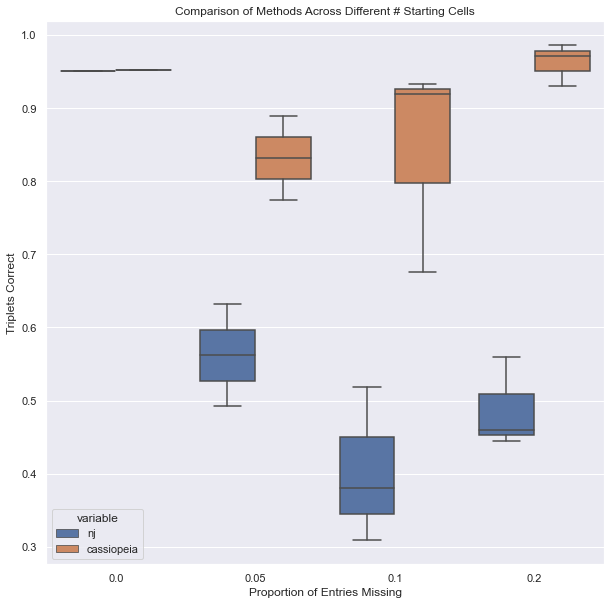

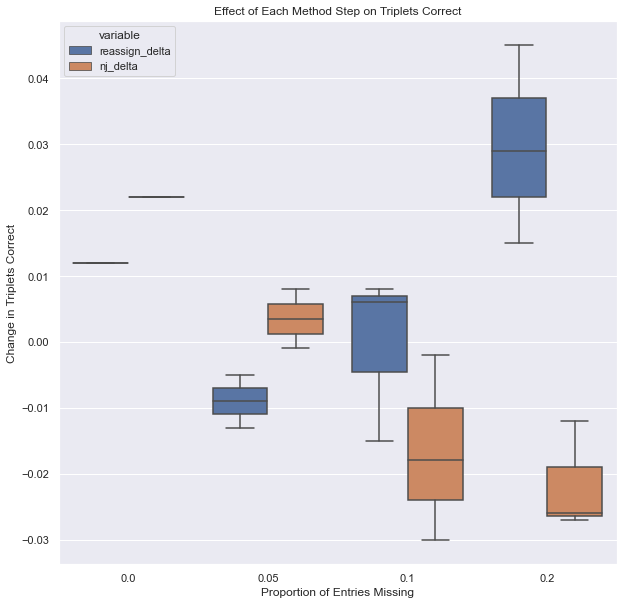

In [24]:
xx = pd.melt(summary_df[['missing','nj','cassiopeia']], id_vars=['missing'])

plt.figure(figsize=(10,10))
sns.boxplot(x='missing', y='value',hue='variable', data=xx)
plt.xlabel('Proportion of Entries Missing')
plt.ylabel('Triplets Correct')
plt.title('Comparison of Methods Across Different # Starting Cells')
plt.show()

xx = pd.melt(summary_df[['missing','reassign_delta', 'nj_delta']], id_vars=['missing'])
xx
plt.figure(figsize=(10,10))
sns.boxplot(x='missing',hue='variable', y='value', data=xx)
plt.xlabel('Proportion of Entries Missing')
plt.ylabel('Change in Triplets Correct')
plt.title('Effect of Each Method Step on Triplets Correct')
plt.show()


In [ ]:
# def format_char_vec(a):
#     nan_a = np.isnan(a)
#     a = a.astype(np.int).astype(str)
#     a[nan_a] = '-'
#     return list(a)

# for simulation in simulation_list:
#     simulation.random_attr['missing_data_expt'] = {'frac':[],'cass':[],'ours':[],'base_score':[]}
#     for frac in [0.05, 0.1, 0.2]:
#         simulation.random_attr['missing_data_expt']['frac'].append(frac)
        
#         priors = None

#         cell_record = simulation.get_cell_record()
#         # Randomly drop mutations to introduce missingness in data 
#         prop = int(cell_record[-1].size * frac)
#         #Randomly choose indices of the numpy array:
#         i = [random.choice(range(cell_record[-1].shape[0])) for _ in range(prop)]
#         j = [random.choice(range(cell_record[-1].shape[1])) for _ in range(prop)]

#         cell_record[-1][i,j] = np.NaN
        
#         # Modify true network to incorporate missing data 
#         import networkx as nx
#         from cassiopeia.TreeSolver.Node import Node

#         # Create networkx DiGraph to represent true_tree 
#         tree = nx.DiGraph()
        
#         # Create nodes representing the leaves
#         level_ix = simulation.subsampled_ix
#         record = cell_record[-1]
#         tips = [Node(str(i), format_char_vec(record[i])) for i in np.arange(len(level_ix))]
        
        
#         ## FIX THIS 
        
#         raise NotImplementedError
        
#         for j in (range(simulation.tree_depth-1, -1, -1)):
#             # Map the subsampled cells from the preceding level as parents/children
#             parent_ix = level_ix//2
#             parent_dict = {}
#             record = cell_record[j]

#             parent_ix_map = dict(zip(np.unique(parent_ix), np.arange(len(np.unique(parent_ix)))))        

#             for i, ix in enumerate(parent_ix):
#                 # Get record corresponding to parent 
#                 parent = parent_dict.get(ix, Node(str(ix), format_char_vec(record[parent_ix_map[ix]])))
#                 parent_dict[ix] = parent
#                 tree.add_edges_from([(parent, tips[i])])

#             # These are the new base layer, and we continue to build upwards
#             level_ix = pd.unique(parent_ix)
#             tips = [parent_dict[ix] for ix in level_ix]
            
#         true_network = tree 
        
        

#         simulation.random_attr['missing_data_expt']['base_score'].append(base_score)
        
#         t = time.time()
#         reconstructed_network_greedy = solve_lineage_instance(target_nodes, 
#                                                               method="greedy", 
#                                                               prior_probabilities=priors)
#         cass_time = time.time()-t
#         cass_tree = reconstructed_network_greedy[0]
#         cass_score = score_triplets(true_network, cass_tree, number_of_trials = 5000, min_size_depth = 20)
#         print('Cassiopeia Score: ', cass_score)
#         print('Cassiopeia Time: ', cass_time)

#         cass = [cass_tree, cass_score, cass_time]
#         simulation.random_attr['missing_data_expt']['cass'].append(cass)
        

#         t = time.time()
#         new_priors = torch.distributions.Categorical(torch.DoubleTensor(simulation.edit_probs))
#         tree, steps = cluster_nx(character_matrix, new_priors)
#         our_time = time.time()-t


#         our_tree = Cassiopeia_Tree(method ='simulated', network = tree)
#         our_score = score_triplets(true_network, our_tree, number_of_trials = 5000, min_size_depth = 20)
#         print('Our Score:', our_score)
#         print('Our Time: ', our_time)
        
#         ours = [our_tree, our_score, our_time]
#         simulation.random_attr['missing_data_expt']['ours'].append(ours)